# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


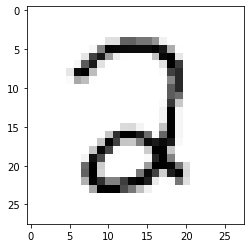

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2517
Training Accuracy: 0.5774, Testing Accuracy: 0.5635



Epoch 10, Loss 0.0859
Training Accuracy: 0.9217, Testing Accuracy: 0.9294



Epoch 20, Loss 0.0527
Training Accuracy: 0.9453, Testing Accuracy: 0.9551



Epoch 30, Loss 0.0416
Training Accuracy: 0.9559, Testing Accuracy: 0.9582



Epoch 40, Loss 0.0361
Training Accuracy: 0.9604, Testing Accuracy: 0.9632



Epoch 50, Loss 0.0328
Training Accuracy: 0.9627, Testing Accuracy: 0.9667



Epoch 60, Loss 0.0305
Training Accuracy: 0.9665, Testing Accuracy: 0.9672



Epoch 70, Loss 0.0288
Training Accuracy: 0.9684, Testing Accuracy: 0.9698



Epoch 80, Loss 0.0274
Training Accuracy: 0.9701, Testing Accuracy: 0.9698



Epoch 90, Loss 0.0262
Training Accuracy: 0.9713, Testing Accuracy: 0.9698



Epoch 100, Loss 0.0252
Training Accuracy: 0.9723, Testing Accuracy: 0.9713



Epoch 110, Loss 0.0244
Training Accuracy: 0.9730, Testing Accuracy: 0.9728



Epoch 120, Loss 0.0236
Training Accuracy: 0.9737, Testing Accuracy: 0.9743



Epoch 130, Loss 0.023
Training Accuracy: 0.9746, Testing Accuracy: 0.9743



Epoch 140, Loss 0.0223
Training Accuracy: 0.9750, Testing Accuracy: 0.9753



Epoch 150, Loss 0.0217
Training Accuracy: 0.9755, Testing Accuracy: 0.9758



Epoch 160, Loss 0.0212
Training Accuracy: 0.9759, Testing Accuracy: 0.9748



Epoch 170, Loss 0.0207
Training Accuracy: 0.9767, Testing Accuracy: 0.9753



Epoch 180, Loss 0.0202
Training Accuracy: 0.9773, Testing Accuracy: 0.9758



Epoch 190, Loss 0.0197
Training Accuracy: 0.9776, Testing Accuracy: 0.9758



Epoch 200, Loss 0.0193
Training Accuracy: 0.9789, Testing Accuracy: 0.9753



Epoch 210, Loss 0.0189
Training Accuracy: 0.9791, Testing Accuracy: 0.9758



Epoch 220, Loss 0.0185
Training Accuracy: 0.9797, Testing Accuracy: 0.9758



Epoch 230, Loss 0.0181
Training Accuracy: 0.9802, Testing Accuracy: 0.9758



Epoch 240, Loss 0.0177
Training Accuracy: 0.9812, Testing Accuracy: 0.9768



0.0256720597829088

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2886
Training Accuracy: 0.5129, Testing Accuracy: 0.5383



Epoch 10, Loss 0.105
Training Accuracy: 0.9104, Testing Accuracy: 0.9279



Epoch 20, Loss 0.0798
Training Accuracy: 0.9262, Testing Accuracy: 0.9446



Epoch 30, Loss 0.0687
Training Accuracy: 0.9346, Testing Accuracy: 0.9496



Epoch 40, Loss 0.062
Training Accuracy: 0.9399, Testing Accuracy: 0.9551



Epoch 50, Loss 0.0575
Training Accuracy: 0.9428, Testing Accuracy: 0.9561



Epoch 60, Loss 0.0541
Training Accuracy: 0.9454, Testing Accuracy: 0.9577



Epoch 70, Loss 0.0515
Training Accuracy: 0.9483, Testing Accuracy: 0.9612



Epoch 80, Loss 0.0494
Training Accuracy: 0.9502, Testing Accuracy: 0.9632



Epoch 90, Loss 0.0477
Training Accuracy: 0.9516, Testing Accuracy: 0.9637



Epoch 100, Loss 0.0463
Training Accuracy: 0.9528, Testing Accuracy: 0.9647



Epoch 110, Loss 0.045
Training Accuracy: 0.9541, Testing Accuracy: 0.9657



Epoch 120, Loss 0.0439
Training Accuracy: 0.9548, Testing Accuracy: 0.9662



Epoch 130, Loss 0.043
Training Accuracy: 0.9558, Testing Accuracy: 0.9662



Epoch 140, Loss 0.0422
Training Accuracy: 0.9564, Testing Accuracy: 0.9662



Epoch 150, Loss 0.0414
Training Accuracy: 0.9569, Testing Accuracy: 0.9672



Epoch 160, Loss 0.0407
Training Accuracy: 0.9574, Testing Accuracy: 0.9667



Epoch 170, Loss 0.0401
Training Accuracy: 0.9582, Testing Accuracy: 0.9672



Epoch 180, Loss 0.0395
Training Accuracy: 0.9587, Testing Accuracy: 0.9672



Epoch 190, Loss 0.039
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0385
Training Accuracy: 0.9593, Testing Accuracy: 0.9677



Epoch 210, Loss 0.0381
Training Accuracy: 0.9594, Testing Accuracy: 0.9677



Epoch 220, Loss 0.0376
Training Accuracy: 0.9599, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0372
Training Accuracy: 0.9601, Testing Accuracy: 0.9677



Epoch 240, Loss 0.0369
Training Accuracy: 0.9603, Testing Accuracy: 0.9677



0.045522073509927985

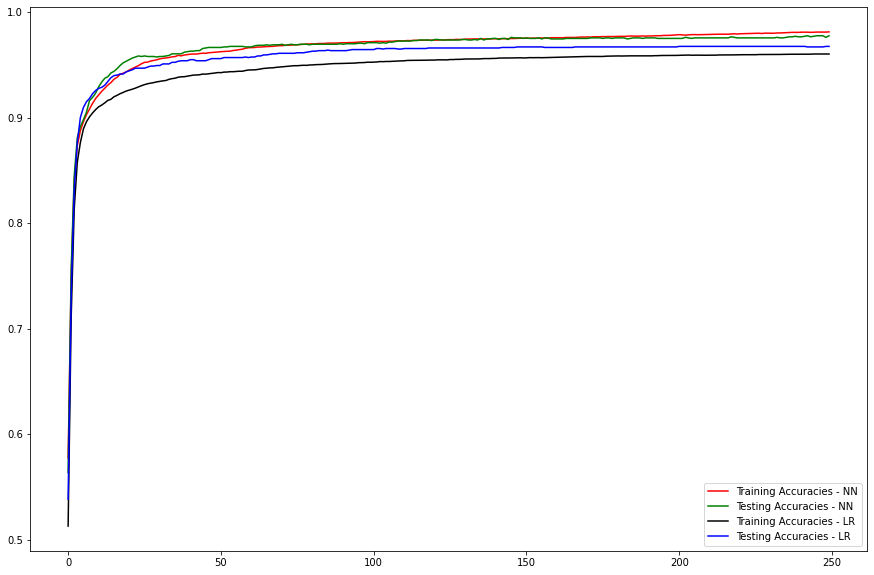

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

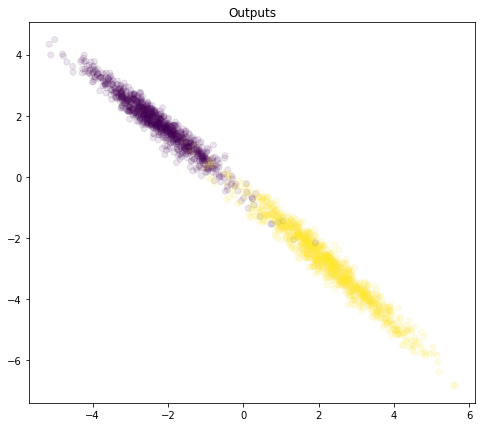

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

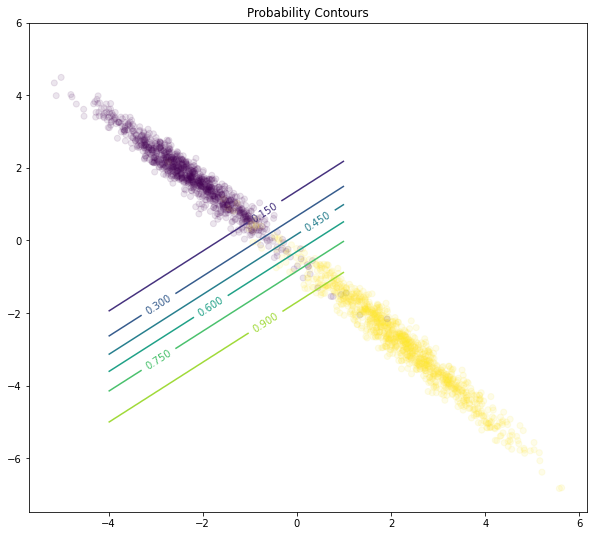

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );